In [1]:
# CTA_STEP 3 (Gadarian)
# Allocate pos/neg words to topics

In [2]:
#import packages
import re
import numpy as np
import pandas as pd
import random

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools

import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



from gensim.models import Word2Vec


import random

import statsmodels.api as sm
import shap

from nltk.tokenize import RegexpTokenizer

from nltk.tokenize.treebank import TreebankWordDetokenizer


import copy
from gensim.models import KeyedVectors

from itertools import combinations

import nltk

from itertools import combinations
from itertools import product

from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import FastText

from scipy.stats import sem
import scipy as sp

from scipy import stats

In [3]:
# Preprosessing is necessary because some steps make reference to the text data
# Step 0: data cleaning

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
# load data
path_data=""

path_graphs=""
df = pd.read_csv(path_data+"gadarian_metadata.csv",sep=",",dtype=str)

df.head(5)

,name,path,anger_ra1,anger_ra2,caseid,enthusiasm_ra1,enthusiasm_ra2,fear_ra1,fear_ra2,immigrants_ra1,immigrants_ra2,legal,open ended response,pid_rep,treat,txtorg_id
0,NaN,NaN,0,0,287,0,0,1,2,0,0,0,problems caused by the influx of illegal immig...,1,1. worried,27417620-757f-11e2-ad47-88532e617cea
1,NaN,NaN,0,0,145,0,0,1,1,0,0,1,"if you mean illegal immigration, i'm afraid of...",1,1. worried,27475b94-757f-11e2-ad47-88532e617cea
2,NaN,NaN,1,1,159,0,0,0,0,0,0,1,that they should enter the same way my grandpa...,0.333,0. think,27484838-757f-11e2-ad47-88532e617cea
3,NaN,NaN,0,1,421,0,0,1,2,0,0,1,legally entering the usa meeting the requireme...,0.5,0. think,274a61fe-757f-11e2-ad47-88532e617cea
4,NaN,NaN,1,0,224,0,0,2,2,0,0,0,terror\nbombings\nkilling us\nrobbing america,0.66667002,1. worried,274c8592-757f-11e2-ad47-88532e617cea


In [6]:
# identify text and ourcome
text=df['open ended response']
outcome=df['treat'].str[0]
metadata=df[['anger_ra1','anger_ra2','enthusiasm_ra1','enthusiasm_ra2',
             'fear_ra1','fear_ra2','immigrants_ra1','immigrants_ra2','legal','pid_rep']]

In [7]:
def sent_to_words_orig(sentences):
    for sentence in sentences:
        yield(str(sentence).split())

# remove stopwords

# Load the spacy model (for other languages, use another spacy model)
nlp = spacy.load('en_core_web_sm')

text = text.apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop]))

# lemmatize text (optional)

text_lemma = text.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

df_tosave=pd.DataFrame({'text':text_lemma,'treatment':outcome, 'text_raw':text})
df_tosave = pd.concat([df_tosave, metadata], axis=1)
df_tosave = df_tosave[df_tosave['text'].str.len() > 0].reset_index(drop=True)

text_lemma=df_tosave['text']
outcome=df_tosave['treatment']
text_orig=df_tosave['text_raw']


words = text_lemma.apply(nltk.word_tokenize)
words_orig = text_orig.apply(nltk.word_tokenize)

# Flatten the list of words
words = [word for sublist in words for word in sublist]
words_orig = [word for sublist in words_orig for word in sublist]

# Create a frequency distribution
freqdist = nltk.FreqDist(words)

sorted_freqdist = sorted(freqdist.items(), key=lambda x: x[1],reverse=True)

# Create a frequency distribution
freqdist_orig = nltk.FreqDist(words_orig)

sorted_freqdist_orig = sorted(freqdist_orig.items(), key=lambda x: x[1],reverse=True)

# Define minimum number of characters
min_characters = 3

# Assuming text_lemma is your lemmatized text
vectorizer = CountVectorizer(min_df=1, token_pattern=r'\b\w{%d,}\b' % min_characters)

# fit the vectorizer on the lemmatized text
X = vectorizer.fit_transform(text_lemma)

# X is a sparse matrix representing the bag-of-words model
# To get the feature names (words), you can use
feature_names = vectorizer.get_feature_names_out()

# To convert the matrix into a DataFrame:
# Here, feature_names (which are your words) are used as column names in the DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=feature_names)

data_words = list(sent_to_words_orig(text_lemma))

data_words_orig = list(sent_to_words_orig(text_orig))

In [8]:
# functions necessary for Step 3

def similarity_cosine(vec1, vec2):
    cosine_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cosine_similarity

def create_cosine_matrix(pretrained_model, word_list):
    vocab_index = pd.DataFrame({'feature_names':word_list,'feature_index':range(1,len(word_list)+1)})
    all_words_dict = {a: x-1 for a, x in vocab_index.values}
    word_index = all_words_dict
    EMBED_DIM = 300
    words_not_found = []
    nb_words = len(word_index)
    embedding_matrix = np.zeros((nb_words, EMBED_DIM))
    emb_name = []
    index = 0
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = pretrained_model.wv[word]
        except KeyError:
            embedding_vector = None
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[index] = embedding_vector
            emb_name.append(word)
            index = index + 1
        else:
            words_not_found.append(word)
    if words_not_found != []:
        print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
        print(f"Some of the words not found:\n{' '.join([random.choice(words_not_found) for x in range(0,10)])}")
    n_words_notfound = embedding_matrix.shape[0] - len(emb_name)
    embedding_matrix = np.delete(embedding_matrix, range(embedding_matrix.shape[0] - len(words_not_found), embedding_matrix.shape[0]), 0)
    embedding_matrix_names = pd.DataFrame(np.transpose(embedding_matrix))
    embedding_matrix_names.columns = emb_name
    cosine_matrix = pd.DataFrame(np.zeros((len(emb_name), len(emb_name))), columns=emb_name, index=emb_name)
    for i in range(cosine_matrix.shape[1]):
        word_1 = cosine_matrix.columns[i]
        for j in range(cosine_matrix.shape[1]):
            word_2 = cosine_matrix.index[j]
            cosine_matrix.iloc[j, i] = similarity_cosine(embedding_matrix_names[word_1], embedding_matrix_names[word_2])
    return cosine_matrix



def calculate_quality_all(words_per_topic, cosine_matrix):
    quality_all_tmp = []
    topic_combinations = list(combinations(range(len(words_per_topic)), 2))
    for i in range(len(topic_combinations)):
        topic_k = topic_combinations[i][0]
        topic_l = topic_combinations[i][1]
        topic_k_words = words_per_topic[topic_k]
        topic_k_words_combinations = list(combinations(topic_k_words, 2))
        topic_l_words = words_per_topic[topic_l]
        topic_l_words_combinations = list(combinations(topic_l_words, 2))

        # coherence_k
        tmp_intra_topic_k = list(combinations(topic_k_words, 2))
        coherence_k = []
        for j in range(len(tmp_intra_topic_k)):
            coherence_tmp = cosine_matrix.loc[topic_k_words_combinations[j][1], topic_k_words_combinations[j][0]]
            coherence_k.append(coherence_tmp)
        coherence_k = np.mean(coherence_k)

        # coherence_l
        tmp_intra_topic_l = list(combinations(topic_l_words, 2))
        coherence_l = []
        for j in range(len(tmp_intra_topic_l)):
            coherence_tmp = cosine_matrix.loc[topic_l_words_combinations[j][1], topic_l_words_combinations[j][0]]
            coherence_l.append(coherence_tmp)
        coherence_l = np.mean(coherence_l)

        # diversity k_l
        topic_k_l_combinations = list(product(topic_k_words, topic_l_words))
        diversity_k_l_combs = []
        for k in range(len(topic_k_l_combinations)):
            diversity_k_l_tmp = cosine_matrix.loc[topic_k_l_combinations[k][1], topic_k_l_combinations[k][0]]
            diversity_k_l_combs.append(diversity_k_l_tmp)
        diversity_k_l = 1 - np.mean(diversity_k_l_combs)

        quality_k_l = (coherence_k + coherence_l) / 2 * diversity_k_l
        quality_all_tmp.append(quality_k_l)

    if len(quality_all_tmp) > 0:
        quality_all = np.mean(quality_all_tmp)
    else:
        quality_all = 0

    return quality_all


def optimize_clusters(grid_alpha, grid_delta, word_importance, cosine_matrix):
    median_distance = np.median(cosine_matrix)
    interpretability_matrix = np.zeros((len(grid_delta), len(grid_alpha)))
    index_m = 0
    for m in grid_delta:
        delta = m
        index_n = 0
        for n in grid_alpha:
            min_distance = median_distance * n
            words_to_drop = []
            cluster_list_groups = []
            mean_shap = []
            impact_shap = []
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
            while len(word_importance_clustering) > 1:
                word_start = word_importance_clustering['Variable'].loc[0]
                cosine_matrix_tmp = cosine_matrix.copy()
                cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=0)
                cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=1)
                word_closest = cosine_matrix_tmp[word_start].nlargest(2).index[1]
                dist_init = cosine_matrix_tmp[word_start].nlargest(2)[1]
                if dist_init > min_distance:
                    mean_dist_words = (cosine_matrix_tmp[word_start] + cosine_matrix_tmp[word_closest]) / 2
                    dist_threshold = dist_init * delta
                    cluster_list_tmp = [word_start, word_closest]
                    dist_words = 1
                    while (dist_words > dist_threshold) & (len(cosine_matrix_tmp) > len(cluster_list_tmp)):
                        mean_dist_words = cosine_matrix_tmp[cluster_list_tmp].mean(axis=1)
                        mean_dist_words.drop(cluster_list_tmp, inplace=True)
                        word_add = mean_dist_words.nlargest(2).index[0]
                        dist_words = mean_dist_words.nlargest(2)[0]
                        cluster_list_tmp.append(word_add)
                    words_to_drop.extend(cluster_list_tmp)
                    cluster_list_groups.append(cluster_list_tmp)
                    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
                else:
                    words_to_drop.extend([word_start])
                    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
            quality_all = calculate_quality_all(cluster_list_groups, cosine_matrix)
            log_nwords = np.log(len([item for sublist in cluster_list_groups for item in sublist]) + 1)
            interpretability = log_nwords * quality_all
            interpretability_matrix[index_m, index_n] = interpretability
            index_n = index_n + 1
        index_m = index_m + 1
    ind = np.unravel_index(np.argmax(interpretability_matrix, axis=None), interpretability_matrix.shape)
    delta = grid_delta[ind[0]]
    alpha = grid_alpha[ind[1]]
    return alpha, delta



def calculate_clusters(method, n_clusters, delta, alpha, cosine_matrix, word_importance):
    words_to_drop = []
    cluster_list_groups = []
    mean_shap = []
    impact_shap = []
    mean_dist_words_topics = []

    median_distance = np.median(cosine_matrix)
    min_distance = alpha * median_distance
    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)

    while len(word_importance_clustering) > 1:
        word_start = word_importance_clustering['Variable'].loc[0]

        cosine_matrix_tmp = cosine_matrix.copy()
        cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=0)
        cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=1)

        word_closest = cosine_matrix_tmp[word_start].nlargest(2).index[1]
        dist_init = cosine_matrix_tmp[word_start].nlargest(2)[1]
        if dist_init > min_distance:
            mean_dist_words = (cosine_matrix_tmp[word_start] + cosine_matrix_tmp[word_closest]) / 2

            dist_threshold = dist_init * delta

            cluster_list_tmp = [word_start, word_closest]

            dist_words = 1
            while (dist_words > dist_threshold) & (len(cosine_matrix_tmp) > len(cluster_list_tmp)):
                mean_dist_words = cosine_matrix_tmp[cluster_list_tmp].mean(axis=1)
                mean_dist_words.drop(cluster_list_tmp, inplace=True)
                word_add = mean_dist_words.nlargest(2).index[0]
                dist_words = mean_dist_words.nlargest(2)[0]
                cluster_list_tmp.append(word_add)
            words_to_drop.extend(cluster_list_tmp)
            cluster_list_groups.append(cluster_list_tmp)
            mean_dist_words_topics_tmp=np.mean(cosine_matrix_tmp[cluster_list_tmp])
            if method != 'freq_only':
                mean_dist_words_topics.append(mean_dist_words_topics_tmp)
                mean_shap.append(word_importance[word_importance['Variable'].isin(cluster_list_tmp)]['word_importance_abs'].mean())
                impact_shap.append(word_importance[word_importance['Variable'].isin(cluster_list_tmp)]['impact'].mean())
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
        else:
            words_to_drop.extend([word_start])
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)

    n_cluster_index = len(cluster_list_groups)
    if n_cluster_index < n_clusters:
        n_clusters_to_use = n_cluster_index
    else:
        n_clusters_to_use = n_clusters

    if method == 'freq_only':
        index_clusters = range(n_clusters_to_use)
    elif method == 'top_shap':
        index_clusters = range(n_clusters_to_use)
    elif method == 'mean_shap':
        index_clusters = np.argpartition(mean_shap, -n_clusters_to_use)[-n_clusters_to_use:]
    elif method == 'impact':
        index_clusters = np.argpartition(impact_shap, -n_clusters_to_use)[-n_clusters_to_use:]
    elif method == 'coherence':
        index_clusters = np.argpartition(mean_dist_words_topics, -n_clusters_to_use)[-n_clusters_to_use:]

    cluster_list_groups = [cluster_list_groups[l] for l in index_clusters]


    return cluster_list_groups, n_cluster_index 


In [9]:
# create word embeddings for clustering

# Load pre-trained model (for another language, use a different pre-trained model)
pretrained_model = FastText.load_fasttext_format("cc.en.300.bin")

# Update the model with new data

pretrained_model.build_vocab(corpus_iterable=data_words, update=True)
pretrained_model.train(corpus_iterable=data_words, total_examples=len(data_words), epochs=pretrained_model.epochs)

(1049, 4698)

In [10]:
# load SHAP values

shap_allwords=pd.read_csv("shap_bert_allwords_010324_train_lemma_shap_lemma.csv")



#remove first column with index
shap_allwords = shap_allwords.iloc[: , 1:]
# copy to new dataframe 
shap_values_matrix=shap_allwords.copy()

In [11]:
#calculate shap mean value and perform t-test
feature_importance = pd.DataFrame({
    'Variable': shap_values_matrix.columns,
    'word_importance': shap_values_matrix.mean(),
    'word_se': sem(shap_values_matrix),
    'word_tval': [stats.ttest_1samp(shap_values_matrix[col], 0)[0] for col in shap_values_matrix.columns],
    'word_pval': [stats.ttest_1samp(shap_values_matrix[col], 0)[1] for col in shap_values_matrix.columns]
}).reset_index(drop=True)
feature_importance = feature_importance.fillna(0)


feature_importance['word_importance_abs']=abs(feature_importance['word_importance'])

freqlist=[]
for i in feature_importance['Variable']:
    if len([item for item in sorted_freqdist if item[0] == i])>0:
        freqlist.append([item for item in sorted_freqdist if item[0] == i][0][1])
    else:
        freqlist.append(0)
        
feature_importance['freq']=freqlist
feature_importance['impact']=feature_importance['freq']*feature_importance['word_importance_abs']



In [12]:
# create descending list with top words for pos/neg, with p-value for SHAP>0 below 0.1
feature_importance_pos=feature_importance[(feature_importance['word_pval']<0.1)&
                                          (feature_importance['word_importance']>0)].reset_index(drop=True)

feature_importance_neg=feature_importance[(feature_importance['word_pval']<0.1)&
                                          (feature_importance['word_importance']<0)].reset_index(drop=True)

feature_importance_pos=feature_importance_pos.sort_values('word_importance_abs',ascending=False).reset_index(drop=True)
feature_importance_neg=feature_importance_neg.sort_values('word_importance_abs',ascending=False).reset_index(drop=True)

#feature_importance_pos=feature_importance_pos.sort_values('word_pval',ascending=True).reset_index(drop=True)
#feature_importance_neg=feature_importance_neg.sort_values('word_pval',ascending=True).reset_index(drop=True)

In [13]:
feature_importance_neg

,Variable,word_importance,word_se,word_tval,word_pval,word_importance_abs,freq,impact
0,mexico,-0.008376,0.002191,-3.822396,0.000157,0.008376,18,0.150760
1,think,-0.004795,0.001234,-3.885167,0.000122,0.004795,53,0.254124
2,mexican,-0.004118,0.001648,-2.499141,0.012910,0.004118,11,0.045294
3,americans,-0.002461,0.000774,-3.178858,0.001611,0.002461,31,0.076295
4,border,-0.002186,0.000821,-2.661635,0.008137,0.002186,40,0.087438
5,american,-0.001994,0.000805,-2.477138,0.013718,0.001994,16,0.031898
6,usa,-0.001690,0.000898,-1.882119,0.060654,0.001690,13,0.021968
7,taxis,-0.001073,0.000573,-1.872294,0.062004,0.001073,28,0.030053
8,close,-0.000430,0.000256,-1.683060,0.093260,0.000430,3,0.001291
9,fair,-0.000419,0.000233,-1.797245,0.073164,0.000419,4,0.001676


In [14]:
# Create distance matrices
cosine_matrix_pos=create_cosine_matrix(pretrained_model,feature_importance_pos['Variable'])

cosine_matrix_neg=create_cosine_matrix(pretrained_model,feature_importance_neg['Variable'])

In [15]:
# find optimal alpha and delta and use optimal values to create clusters
grid_alpha=np.arange (0.4, 4, 0.2)
grid_delta=np.arange (0.4, 1, 0.1)

alpha, delta = optimize_clusters(grid_alpha, grid_delta, feature_importance_pos, cosine_matrix_pos)
print(alpha, delta)
cluster_list_groups_pos, n_cluster_index_pos = calculate_clusters('top_shap', 2, delta, alpha, cosine_matrix_pos, feature_importance_pos)


alpha, delta = optimize_clusters(grid_alpha, grid_delta, feature_importance_neg, cosine_matrix_neg)
print(alpha, delta)
cluster_list_groups_neg, n_cluster_index_neg = calculate_clusters('top_shap', 2, delta, alpha, cosine_matrix_neg, feature_importance_neg)

2.6000000000000005 0.8999999999999999
0.4 0.7


In [16]:
# total number of clusters for pos/neg

print(n_cluster_index_pos)
print(n_cluster_index_neg)

20
2


In [17]:
# print top (as specified in calculate_clusters function above) clusters
print('positive:')
print(cluster_list_groups_pos)
print('negative:')
print(cluster_list_groups_neg)

positive:
[['job', 'work', 'worker'], ['pay', 'money', 'cost']]
negative:
[['mexico', 'mexican', 'american', 'americans', 'usa', 'border'], ['think', 'fair', 'close']]


The rest of the notebook computes different validations of the model

In [18]:
# calcluate quality for top clusters

quality_pos=calculate_quality_all(cluster_list_groups_pos, cosine_matrix_pos)
print('quality positive:')
print(quality_pos)


quality_neg=calculate_quality_all(cluster_list_groups_neg, cosine_matrix_neg)
print('quality negative:')
print(quality_neg)

quality positive:
0.3603378776130951
quality negative:
0.31101553218968375


In [19]:
# make one list of all positive and negative topics and calculate sentiment for each topic with Vader
cluster_list_groups_all=cluster_list_groups_pos+cluster_list_groups_neg
cluster_list_groups_all

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

analyzer = SentimentIntensityAnalyzer()

# Initialize an empty list to hold the average compound scores
average_scores = []

# Loop over the sublists
for sublist in cluster_list_groups_all:
    # Initialize a variable to hold the sum of the compound scores
    compound_sum = 0
    # Loop over the words in the sublist
    for word in sublist:
        # Get the sentiment scores
        sentiment = analyzer.polarity_scores(word)
        # Add the compound score to the sum
        compound_sum += sentiment['compound']
    # Calculate the average compound score and add it to the list of average scores
    average_scores.append(compound_sum / len(sublist))

# Print the average compound scores
for i, score in enumerate(average_scores):
    print(f"Average compound score for sublist {i + 1}: {score}")

Average compound score for sublist 1: 0.0
Average compound score for sublist 2: -0.03423333333333333
Average compound score for sublist 3: 0.0
Average compound score for sublist 4: 0.10606666666666666


In [20]:
# Create dummy variables for each sublist in cluster_list_groups_pos
for i, sublist in enumerate(cluster_list_groups_pos, start=1):
    var_name = f'topic_dummy pos {i}'
    globals()[var_name] = text_lemma.apply(lambda x: any(word in x for word in sublist)).astype(int)
    
for i, sublist in enumerate(cluster_list_groups_neg, start=1):
    var_name = f'topic_dummy neg {i}'
    # Create a dummy variable for each sublist
    globals()[var_name] = text_lemma.apply(lambda x: any(word in x for word in sublist)).astype(int)

# Now you can access the variables like topic_pos_1, topic_pos_2, etc.

# Create a DataFrame with the topic dummies and the variable "outcome"
df_reg = pd.DataFrame()
for i in range(1, len(cluster_list_groups_pos) + 1):
    df_reg[f'Treatment Topic {i}'] = globals()[f'topic_dummy pos {i}']
for i in range(1, len(cluster_list_groups_neg) + 1):
    df_reg[f'Control Topic {i}'] = globals()[f'topic_dummy neg {i}']
df_reg['outcome'] = outcome

df_reg.describe()

,Treatment Topic 1,Treatment Topic 2,Control Topic 1,Control Topic 2
count,349.00000,349.000000,349.000000,349.000000
mean,0.30086,0.191977,0.280802,0.137536
std,0.45929,0.394421,0.450036,0.344907
min,0.00000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000
75%,1.00000,0.000000,1.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000


In [21]:
# create a variable for each topic with the total shap value for all words in topic per answer

for i, sublist in enumerate(cluster_list_groups_pos, start=1):
    var_name = f'topic pos {i}'
    globals()[var_name] = shap_values_matrix[sublist].sum(axis=1)
    
for i, sublist in enumerate(cluster_list_groups_neg, start=1):
    var_name = f'topic neg {i}'
    globals()[var_name] = shap_values_matrix[sublist].sum(axis=1)

In [22]:
# Create a DataFrame with the topic weights and the variable "outcome"
df_reg = pd.DataFrame()
for i in range(1, len(cluster_list_groups_pos) + 1):
    df_reg[f'Treatment Topic {i}'] = globals()[f'topic pos {i}']
for i in range(1, len(cluster_list_groups_neg) + 1):
    df_reg[f'Control Topic {i}'] = globals()[f'topic neg {i}']*(-1)
#df_reg['outcome'] = outcome
df_reg['outcome'] = df_tosave['treatment']

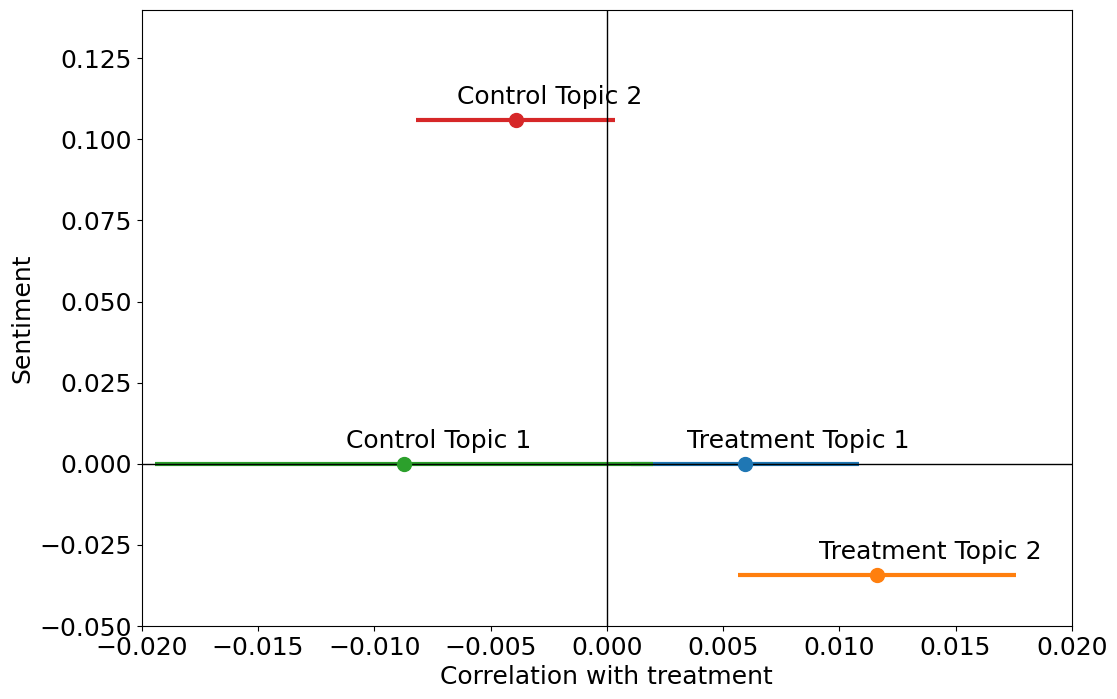

In [28]:
# create plot with regression of topic on outcome and with sentiment

# Convert DataFrame to numeric data type
df_reg = df_reg.apply(pd.to_numeric, errors='coerce')


# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_reg.columns:
    if column != 'outcome':
        X = df_reg['outcome']
        y = df_reg[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)
        
coeff_sentiment=pd.DataFrame({'topic':df_reg.columns[df_reg.columns != 'outcome'],
                              'coefficient':coefficients,'sentiment':average_scores, 'conf_intervals':conf_intervals})   
# Create scatterplot
plt.figure(figsize=(12, 8))  # Increase plot size

# Add error bars
for i in range(coeff_sentiment.shape[0]):
    x = coeff_sentiment['coefficient'][i]
    y = coeff_sentiment['sentiment'][i]
    ci = coeff_sentiment['conf_intervals'][i]
    plt.errorbar(x, y, xerr=np.array([[x - ci[0]], [ci[1] - x]]), 
                 fmt='o', markersize=10, linewidth=3)  # Increase markersize and linewidth here

# Add labels
offset_y = 0.005 
offset_x = 0.0025 # Adjust this value to move the labels up or down
for i in range(coeff_sentiment.shape[0]):
    plt.text(coeff_sentiment['coefficient'][i] - offset_x, 
             coeff_sentiment['sentiment'][i] + offset_y, coeff_sentiment['topic'][i], fontsize=18)  # Increase font size here

plt.axhline(0, color='black',linewidth=1)  # Add y-axis line at 0
plt.axvline(0, color='black',linewidth=1)  # Add x-axis line at 0

# Define axis limits
plt.xlim([-0.02, 0.02])  # Set x-axis limits
plt.ylim([-0.05, 0.14])  # Set y-axis limits

plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here
plt.ylabel('Sentiment', fontsize=18)  # Increase font size here
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title('CTA: Scatterplot of Treatment Coefficients and Sentiment', fontsize=16)  # Increase font size here
# plt.grid(True)
plt.savefig(path_graphs+'cta_topic_treatment_gadarian.png',bbox_inches='tight')
plt.show()


In [24]:
# quality for all topics

# Flatten the list of lists into a single list
all_words_cluster_list_groups_all = [word for sublist in cluster_list_groups_all for word in sublist]
# Remove duplicates by converting the list to a set
unique_words = set(all_words_cluster_list_groups_all)

# Convert the set back to a list
all_words_cluster_list_groups_all = list(unique_words)

cosine_matrix_alltopics = create_cosine_matrix(pretrained_model, all_words_cluster_list_groups_all)
round(calculate_quality_all(cluster_list_groups_all, cosine_matrix_alltopics),2)

0.35

In [25]:
df_reg=df_reg[['Treatment Topic 1','Treatment Topic 2','Control Topic 1','Control Topic 2','outcome']]

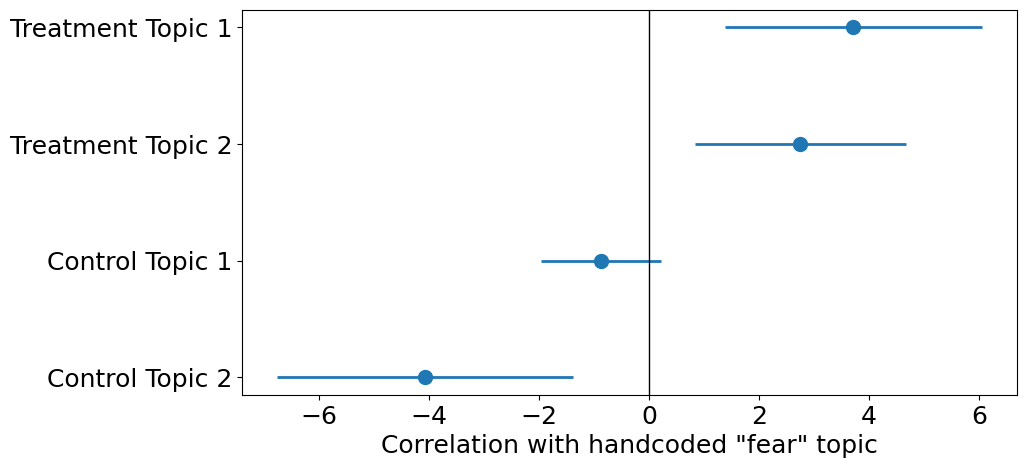

In [26]:
# regression of topics on RA1 fear (manually coded by RA1)
df_reg2=pd.concat([df_reg, df_tosave], axis=1)
# Convert DataFrame to numeric data type
df_reg2 = df_reg2.apply(pd.to_numeric, errors='coerce')
outcome_tocheck=pd.to_numeric(df_reg2['fear_ra1'])
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_reg.columns:
    if column != 'outcome':
        X = df_reg2[column]
        y = outcome_tocheck
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2
topic_order=np.arange(len(coefficients),0,-1)-1
# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

# Increase font size for y-axis labels
plt.yticks(topic_order, df_reg.columns[df_reg.columns != 'outcome'], fontsize=font_size)

# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)
plt.axvline(0, color='black',linewidth=1)
plt.xlabel('Correlation with handcoded "fear" topic', fontsize=18)  # Increase font size here


plt.savefig(path_graphs+'cta_topic_treatment_RA1_fear_gadarian.png',bbox_inches='tight')
plt.show()

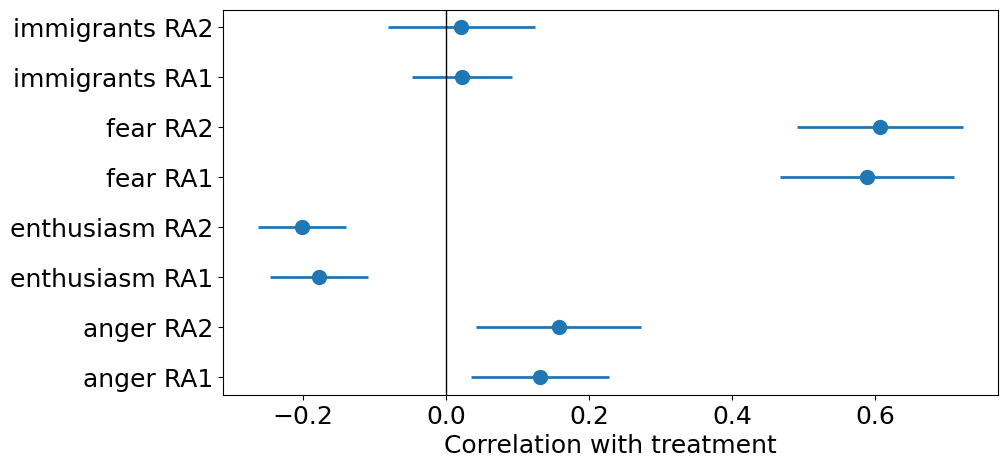

In [34]:
#plot all handcoded topics
# Convert DataFrame to numeric data type
df_tosave_ra=df_tosave[['anger_ra1','anger_ra2','enthusiasm_ra1','enthusiasm_ra2',
             'fear_ra1','fear_ra2','immigrants_ra1','immigrants_ra2','treatment']]
df_tosave_ra = df_tosave_ra.apply(pd.to_numeric, errors='coerce')
df_tosave_ra.columns=['anger RA1','anger RA2','enthusiasm RA1','enthusiasm RA2',
             'fear RA1','fear RA2','immigrants RA1','immigrants RA2','treatment']

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_tosave_ra.columns:
    if column != 'treatment':
        X = df_tosave_ra['treatment']
        y = df_tosave_ra[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
# Define your desired font size, marker size, and line width
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, np.arange(len(coefficients)), 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

# Increase font size for y-axis labels
plt.yticks(np.arange(len(coefficients)), df_tosave_ra.columns[df_tosave_ra.columns != 'treatment'], fontsize=font_size)

# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)

# Add a title with increased font size
# plt.title('Coefficients and 90% Confidence Intervals of Treatment effect on RA topics', fontsize=font_size)
plt.axvline(0, color='black',linewidth=1)
plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here


plt.savefig(path_graphs+'treatment_ra_topics_gadarian.png',bbox_inches='tight')
plt.show()

In [77]:
# make plots from embeddings (then transfer to R for better rendering)

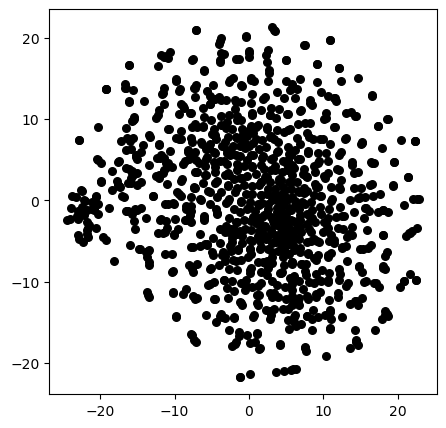

In [64]:
#all words
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set seed for reproducibility
np.random.seed(42)

# Get the words from feature_importance['Variable']
important_features = feature_importance['Variable'].tolist()

# Filter feature_names
filtered_feature_names = [word for word in important_features if word in pretrained_model.wv.key_to_index]

# Get the word vectors for the words in filtered_feature_names
word_vectors = [pretrained_model.wv[word] for word in filtered_feature_names]

# Convert list to numpy array
word_vectors_np = np.array(word_vectors)

# Use t-SNE for dimensionality reduction
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
new_values = tsne_model.fit_transform(word_vectors_np)

# Create a dataframe
tsne_df_step1 = pd.DataFrame({'X':new_values[:, 0], 'Y':new_values[:, 1], 'Word':filtered_feature_names})

# Plot the word embeddings
plt.figure(figsize=(5, 5)) 
for i in range(len(tsne_df_step1)):
    plt.scatter(tsne_df_step1.X[i],tsne_df_step1.Y[i], color='black', s=30)  # s parameter controls the size of the dots
plt.show()

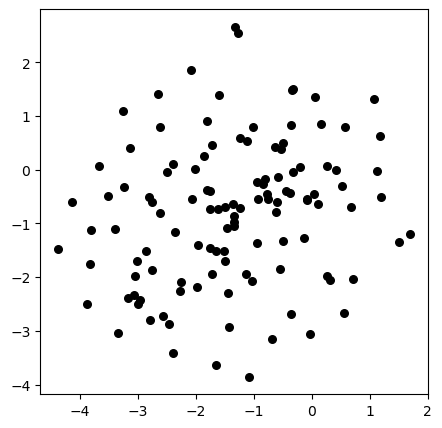

In [65]:
#positive words

# Set seed for reproducibility
np.random.seed(42)

# Get the words from feature_importance['Variable']
important_features = feature_importance_pos['Variable'].tolist()

# Filter feature_names
filtered_feature_names = [word for word in important_features if word in pretrained_model.wv.key_to_index]

# Get the word vectors for the words in filtered_feature_names
word_vectors = [pretrained_model.wv[word] for word in filtered_feature_names]

# Convert list to numpy array
word_vectors_np = np.array(word_vectors)

# Use t-SNE for dimensionality reduction
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
new_values = tsne_model.fit_transform(word_vectors_np)

# Create a dataframe
tsne_df_step2 = pd.DataFrame({'X':new_values[:, 0], 'Y':new_values[:, 1], 'Word':filtered_feature_names})

# Plot the word embeddings
plt.figure(figsize=(5, 5)) 
for i in range(len(tsne_df_step2)):
    plt.scatter(tsne_df_step2.X[i],tsne_df_step2.Y[i], color='black', s=30)  # s parameter controls the size of the dots
plt.show()

In [73]:
# calculate top 4 topics for positive
alpha, delta = optimize_clusters(grid_alpha, grid_delta, feature_importance_pos, cosine_matrix_pos)

cluster_list_groups_pos, n_cluster_index_pos = calculate_clusters('top_shap', 4, delta, alpha, cosine_matrix_pos, feature_importance_pos)

In [74]:
cluster_list_groups_pos

[['job', 'work', 'worker'],
 ['pay', 'money', 'cost'],
 ['illegal', 'illegally', 'legally'],
 ['come', 'bring', 'get', 'want', 'need', 'give', 'take']]

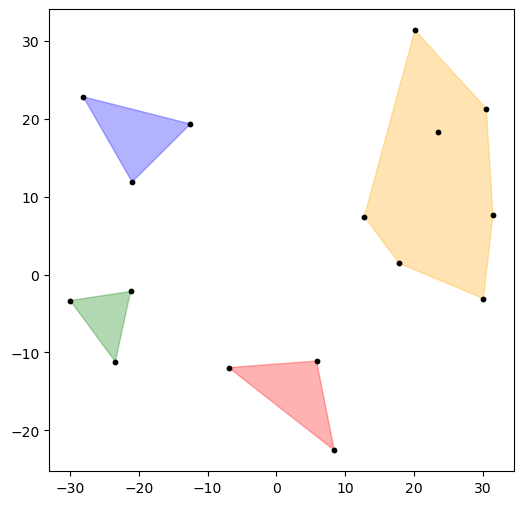

In [75]:
# plot positive topics

from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches


# Assign colors to each group
group_colors = ['red', 'blue', 'green', 'orange']

# Filter word vectors and words based on the subset
subset_word_vectors = []
subset_words = []
for group in cluster_list_groups_pos:
    for word in group:
        if word in pretrained_model.wv.key_to_index:
            subset_word_vectors.append(pretrained_model.wv[word])
            subset_words.append(word)

# Convert list to numpy array
subset_word_vectors_np = np.array(subset_word_vectors)

# Use t-SNE for dimensionality reduction
tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=42)
new_values = tsne_model.fit_transform(subset_word_vectors_np)

# Create a dataframe
tsne_df_step3 = pd.DataFrame({'X':new_values[:, 0], 'Y':new_values[:, 1], 'Word':subset_words})

# Plot the word embeddings
fig, ax = plt.subplots(figsize=(6, 6))

# Add encircling for each group with colors
for i, group in enumerate(cluster_list_groups_pos):
    group_vectors = [new_values[j] for j in range(len(new_values)) if subset_words[j] in group]
    if len(group_vectors) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(group_vectors)
        polygon_points = [group_vectors[vertex] for vertex in hull.vertices]
        poly = mpatches.Polygon(polygon_points, closed=True, alpha=0.3, color=group_colors[i])
        ax.add_patch(poly)

# Create the base scatter plot
plt.scatter(tsne_df_step3.X, tsne_df_step3.Y, color='black', s=10)
plt.show()

In [77]:
#save t-sne for rendering in R

tsne_df_step1.to_csv("tsne_df_step1.csv")
tsne_df_step2.to_csv("tsne_df_step2.csv")
tsne_df_step3.to_csv("tsne_df_step3.csv")
